# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

!pip install torchinfo
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.utils as vutils

import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install deeplake
import deeplake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 k

In [3]:
seed = 3407
# "torch.manual seed(3407) is all you need" (Picard 2021)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # includes CUDA 

In [4]:
print('CUDA version:', torch.version.cuda)
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA version: 11.8
PyTorch version: 2.0.1+cu118


In [5]:
# experiment w/ diff values!

BATCH_SIZE = 64 # temporarily changed in training code below to 32
IMG_SIZE = 64
EPOCHS = 1 # for now

# read if you want: why mini-batch sizes are typically powers of 2:
# https://stackoverflow.com/questions/44483233/is-using-batch-size-as-powers-of-2-faster-on-tensorflow

#  large-batch methods tend to converge to sharp minimizers of the training function. These minimizers are characterized by large positive eigenvalues in 
# ∇^2𝑓(𝑥) and tend to generalize less well. In contrast, small-batch methods converge to flat minimizers characterized by 
# small positive eigenvalues of ∇^2𝑓(𝑥)

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data

In [7]:
ds = deeplake.load('hub://activeloop/wiki-art')

\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/wiki-art



|

hub://activeloop/wiki-art loaded successfully.



In [8]:
class_names = np.unique(ds.labels.data()['text'])
n_class = len(class_names)

## Dataloader

## to-do: uncomment and add more transformations. then maybe make an untouched separate tform and dataset just for visualizations where there are no crops and stuff

In [9]:
tform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    # transforms.CenterCrop(IMG_SIZE*0.5),
    # transforms.RandomCrop(IMG_SIZE*0.75, padding=2),
    # transforms.RandomHorizontalFlip(),   
    
    # ^ not so simple. uncommenting these sometimes leads to visualization errors (transformation fails idk)
    # also uncommenting makes the visualizations weird as you can imagine
    
    # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # ^ this maps the range [0, 1] into [-1, 1], because the minimum value 0 will be converted to 
    # (0-0.5)/0.5 = -1 and 1 -> (1-0.5)/0.5 = 1
    # this was used in the example I'm following
    
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # ^ another option. i.e. for the 1st channel we have mean = 0.485, std = 0.229, etc.
    # these avlues are calculated from ImageNet, so they are standard practice. 
    # you can calculate the new mean and std on your training data but otherwise using the Imagenet pretrained 
    # model with its own mean and std is recommended. 
])

In [10]:
# for reverting normalization for visualization purposes
invTrans = transforms.Normalize(
                mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                std=[1 / 0.229, 1 / 0.224, 1 / 0.225])

## Dataset

In [11]:
class PaintingDataset(Dataset):
    '''
    '''
    def __init__(self, ds, transform = None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        image = self.ds.images[idx].numpy()
        label = self.ds.labels[idx].numpy(fetch_chunks = True).astype(np.int32)
        # When loading data sequentially, or when randomly loading samples from a tensor that fits 
        # into the cache (such as class_labels) it is recommended to set fetch_chunks = True. 
        # This increases the data loading speed by avoiding separate requests for each individual sample.
        # This is not recommended when randomly loading large tensors, because the data is deleted from the 
        # cache before adjacent samples from a chunk are used.

        if self.transform is not None:
            image = self.transform(image)

        sample = {"images": image, "labels": label}

        return sample

In [12]:
dataset = PaintingDataset(ds, transform = tform)

## Dataloader

In [13]:
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 0, shuffle = True, pin_memory=True)
# remark on pin_memory:
# If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, 
# you can speed up the host to device transfer by enabling pin_memory.
# This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer.

## Visualization

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-50-939645bfc769>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,4,i+1)


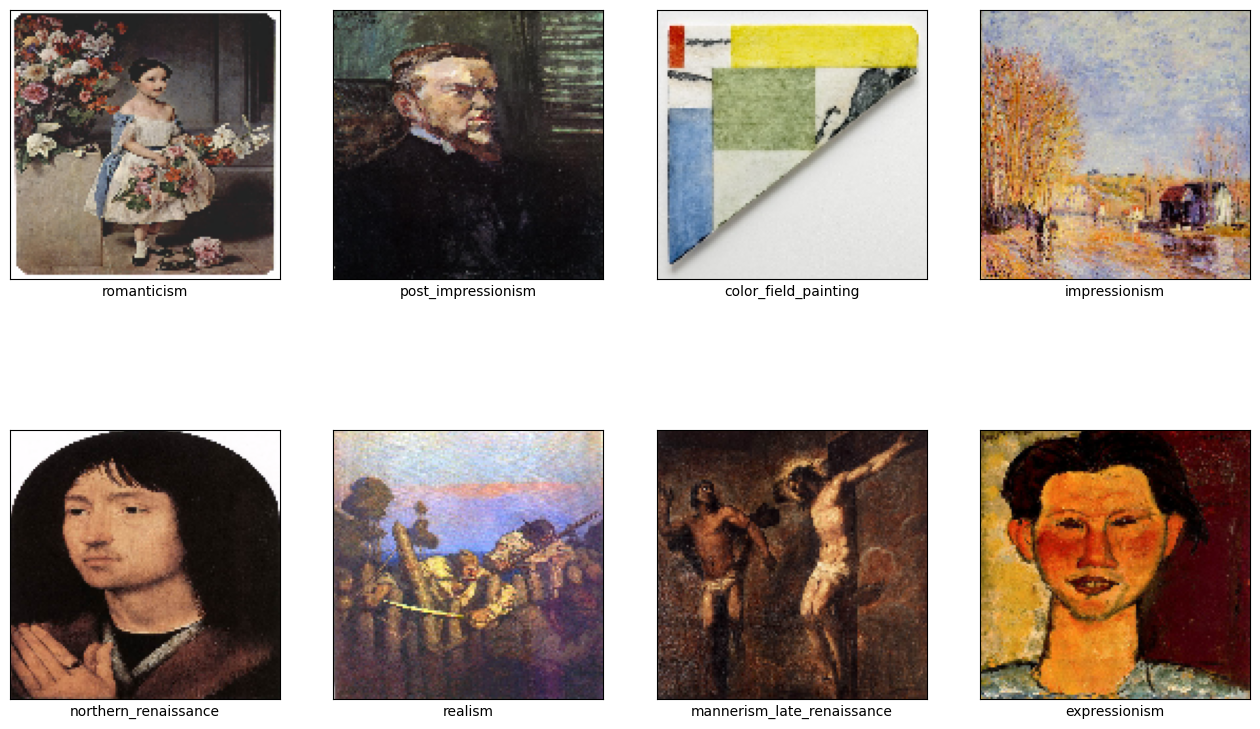

In [ ]:
plt.figure(figsize=(16,10))
plt.title('Training Images')

images, labels = next(iter(dataloader)).values()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = invTrans(images[i]) # reverts image normalizations for display purposes  
    image = np.transpose(image.cpu(), (1,2,0))
    plt.imshow(image)
    plt.xlabel(class_names[labels[i]])
plt.show()

# Model

In [14]:
# Remarks:

# Conv2D is mainly used when you want to detect features, e.g., in the encoder part of an autoencoder model, 
# and it may shrink your input shape. Conversely, Conv2DTranspose is used for creating features, for example,
# in the decoder part of an autoencoder model for constructing an image. It makes the input shape larger.

# In GANs, the recommendation is to not use pooling or fully-connected layers

## Generator

In [15]:
class Generator(torch.nn.Module):
            
    def __init__(self):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(128, 512, kernel_size=5) # 128 just a hyperparameter for noise vector (did not make as a constant as of now)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=3, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=3, padding=2)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=1, padding=2)
        
        self.relu = nn.ReLU()
        # ReLU is recommended for the generator, but not for the discriminator
        self.tanh = nn.Tanh()
        # note ReLU should only be used within hidden layers. for generator output layer we use tanh
        
    def forward(self, x):
        x = self.bn1(self.relu(self.conv1(x)))
        x = self.bn2(self.relu(self.conv2(x)))
        x = self.bn3(self.relu(self.conv3(x)))
        x = self.bn4(self.relu(self.conv4(x)))
        x = self.tanh(self.conv5(x))
        return x
    
        # We use relu before BN = design choice. BN needs to come last after relu to properly do its job of normalizing layer inputs

In [16]:
summary(Generator(), (64, 128, 1, 1))
# recall we feed the generator noise, not a painting
# so we're feeding it torch.randn(batch_size, size of noise "image", 1, 1, device=device)
# and we get out [batch_size, 3 (# of channels), image_size, image_size], in other words a properly sized image

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [64, 3, 64, 64]           --
├─ConvTranspose2d: 1-1                   [64, 512, 5, 5]           1,638,912
├─ReLU: 1-2                              [64, 512, 5, 5]           --
├─BatchNorm2d: 1-3                       [64, 512, 5, 5]           1,024
├─ConvTranspose2d: 1-4                   [64, 256, 9, 9]           3,277,056
├─ReLU: 1-5                              [64, 256, 9, 9]           --
├─BatchNorm2d: 1-6                       [64, 256, 9, 9]           512
├─ConvTranspose2d: 1-7                   [64, 128, 23, 23]         295,040
├─ReLU: 1-8                              [64, 128, 23, 23]         --
├─BatchNorm2d: 1-9                       [64, 128, 23, 23]         256
├─ConvTranspose2d: 1-10                  [64, 64, 65, 65]          73,792
├─ReLU: 1-11                             [64, 64, 65, 65]          --
├─BatchNorm2d: 1-12                      [64, 64, 65, 65]

In [17]:
# test = nn.Sequential(
#     nn.ConvTranspose2d(128, 512, kernel_size=5),
#     nn.BatchNorm2d(512),
#     nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2),
#     nn.BatchNorm2d(256),
#     nn.ConvTranspose2d(256, 128, kernel_size=3, stride=3, padding=2),
#     nn.BatchNorm2d(128),
#     nn.ConvTranspose2d(128, 64, kernel_size=3, stride=3, padding=2),
#     nn.BatchNorm2d(64),
#     nn.ConvTranspose2d(64, 3, kernel_size=4, stride=1, padding=2),
# )

# input = torch.randn(64, 128, 1, 1)
# output = test(input)
# print(output.size())

## Discriminator

In [18]:
class Discriminator(torch.nn.Module):
            
     # input 64 (batch size) x 3 (channels) x 64 x 64 (image size)
        
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=3, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=3, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=3, padding=2)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.relu = nn.LeakyReLU(0.1)
        # LeakyRELU is popular in tasks where we may suffer from sparse gradients, 
        # for example, training GANs
        
        self.discriminate = nn.Sequential(
            # instead of linear layer 256 to 1?
            nn.Conv2d(256, 1, kernel_size=3),
            nn.Sigmoid())
        
        self.classify = nn.Sequential(
            nn.Conv2d(256, n_class, kernel_size=3))
            # in place of linear layers and softmax?
            # nn.Linear(256, 1024),
            # nn.LeakyReLU(0.1),
            # nn.Linear(1024, 512),
            # nn.LeakyReLU(0.1),
            # nn.Linear(512, n_class),
            # nn.Softmax(dim=1)) ???
            
    def forward(self, x):
        x = self.bn1(self.relu(self.conv1(x)))
        x = self.bn2(self.relu(self.conv2(x)))
        x = self.bn3(self.relu(self.conv3(x)))
        x = self.bn4(self.relu(self.conv4(x)))
            
        disc_p = self.discriminate(x)
        style_p = self.classify(x)
        return disc_p, style_p
    
        # note we use relu before BN, design choice. BN needs to come last after relu and pooling to properly
        # do its job of normalizing layer inputs

In [19]:
summary(Discriminator(), (64, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [64, 1, 1, 1]             --
├─Conv2d: 1-1                            [64, 32, 32, 32]          1,568
├─LeakyReLU: 1-2                         [64, 32, 32, 32]          --
├─BatchNorm2d: 1-3                       [64, 32, 32, 32]          64
├─Conv2d: 1-4                            [64, 64, 11, 11]          51,264
├─LeakyReLU: 1-5                         [64, 64, 11, 11]          --
├─BatchNorm2d: 1-6                       [64, 64, 11, 11]          128
├─Conv2d: 1-7                            [64, 128, 5, 5]           73,856
├─LeakyReLU: 1-8                         [64, 128, 5, 5]           --
├─BatchNorm2d: 1-9                       [64, 128, 5, 5]           256
├─Conv2d: 1-10                           [64, 256, 3, 3]           295,168
├─LeakyReLU: 1-11                        [64, 256, 3, 3]           --
├─BatchNorm2d: 1-12                      [64, 256, 3, 3]           

In [20]:
# # for testing

# test2 = nn.Sequential(
#         nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
#         nn.BatchNorm2d(32),
#         nn.Conv2d(32, 64, kernel_size=5, stride=3, padding=2),
#         nn.BatchNorm2d(64),
#         nn.Conv2d(64, 128, kernel_size=3, stride=3, padding=2),
#         nn.BatchNorm2d(128),
#         nn.Conv2d(128, 256, kernel_size=3, stride=3, padding=2),
#         nn.BatchNorm2d(256),
#         nn.Conv2d(256, 1, kernel_size=3),
#         nn.Sigmoid()
#         # nn.Conv2d(256, n_class, kernel_size=3)
# )

# input2 = torch.randn(64, 3, 64, 64)
# output2 = test2(input2)
# print(output2.size())

In [21]:
def weight_init(model_layer):
    '''
    TO-DO
    meant to be used with model.apply(weight_init) such that the function is called for each model layer
    '''
    layer_name = model_layer.__class__.__name__
    if layer_name.find('Conv') != -1:
        # Ads Xavier initialization to convolutional layers
        # design choice to use normal distribution rather than uniform.
        # Recall Xavier initialization initializes weights such that the variance of the 
        # activations are the same across every layer; this prevents the gradient from exploding or vanishing
        nn.init.xavier_normal_(model_layer.weight.data)
    elif layer_name.find('BatchNorm') != -1:
        # batchnorm layer only has dim 1 so cannot compute fan in fan out values for Xavier initialization
        nn.init.normal_(model_layer.weight.data, 0, 0.02)
        nn.init.constant_(model_layer.bias.data, 0)

# Initialization and setup

In [22]:
gen = Generator().to(device)
disc = Discriminator().to(device)

In [23]:
gen.apply(weight_init);
disc.apply(weight_init);

In [24]:
loss = nn.BCELoss()
style_loss = nn.CrossEntropyLoss()

In [88]:
# For visualization of training process
# 128 is just a hyperparameter. but I didn't make it a constant so if you change this you gotta change Generator model architecture and all that
fixed_noise = torch.randn(BATCH_SIZE, 128, 1, 1, device=device)

In [26]:
# Real vs. fake labels training (as floats)
real_label = 1.
fake_label = 0.

In [27]:
# Setup AdamW optimizers for both G and D
optimizer_D = optim.AdamW(disc.parameters(), lr=0.001)
optimizer_G = optim.AdamW(gen.parameters(), lr=0.001)

# Training (temporarily archived, scroll down for subset training)

In [52]:
# When retrieving a batch with
# x, y = next(iter(training_loader))
# you actually create a new instance of dataloader iterator at each call (!)

# What you should do instead is create the iterator once (per epoch):
# training_loader_iter = iter(training_loader)

# and then call next for each batch on the iterator:
# for i in range(num_batches_in_epoch):
#   x, y = next(training_loader_iter)

In [60]:
img_list = []
G_losses = []
D_losses = []
entropies = []
iters = 0

print("Beginning model training:")

for epoch in range(EPOCHS):
  data_iter = iter(dataloader)
  for i in range(len(dataloader)): # num of batches in epoch
    img, style_label = next(data_iter).values()
    print(f"Batch {i} obtained")
    # Part A: Train discriminator
    # i) Real painting data
    disc.zero_grad()

    style_label = style_label.to(device)
    img_cpu = img.to(device)
    label = torch.full((BATCH_SIZE,), real_label, dtype=torch.float, device=device)

    # Forward pass real batch through discriminator
    output, output_style = disc(img_cpu)
    # Calculate loss on all-real batch
    errD_real = loss(output.squeeze(), label)
    # think I need to squeeze here
    style_label = style_label.to(torch.long) # equivalent to torch.int64. just annoying thing about categorical CE loss function input
    errD_real = errD_real + style_loss(output_style.squeeze(), style_label.squeeze())
    # Calculate gradients in backward pass
    errD_real.backward()
    D_x = output.mean().item()
    
    # ii) Generated batch
    noise = torch.randn(BATCH_SIZE, 128, 1, 1, device=device)
    fake = gen(noise)
    label.fill_(fake_label)

    # Forward pass
    output, output_style = disc(fake.detach())
    # Calculate loss on fake batch
    errD_fake = loss(output.squeeze(), label)
    # think I need to squeeze here
    # Calculate the gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()

    # Compute discriminator total loss
    errD = errD_real + errD_fake
    # Update discriminator
    optimizer_D.step()

    # Part B: Train generator
    gen.zero_grad()
    
    label.fill_(real_label)  # fake labels are real for generator cost
    # ^ TO-UNDERSTAND
    # After updating discriminator, perform another forward pass of fake batch to compute new loss
    output, output_style = disc(fake.detach())
    # ^ probably needs detach right?

    # Uniform cross entropy
    logsoftmax = nn.LogSoftmax(dim=1)
    unif = torch.full((BATCH_SIZE, n_class), 1/n_class)
    unif = unif.to(device)
    # Calculate G's loss based on this output
    errG = loss(output.squeeze(), label)
    # think I need to squeeze here
    errG = errG + torch.mean(-torch.sum(unif * logsoftmax(output_style), 1))
    # to-understand. unconfirmed explanation: so we're summing across each row (an image), and there are 27 columns (styles).
    # This means each image (row) has predicted probabilities for each style (27), which are determined by 1/27 * logsoftmax(output_style)
    # we take the negative of the row sums and find the mean of that and thats our loss, negative because we don't want the discriminator to classify
    # style correctly

    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizer_G.step()

    # TO-UNDERSTAND: 
    style_entropy = -1 * (nn.functional.softmax(output_style, dim=1) * nn.functional.log_softmax(output_style, dim=1))
    # I think adding this log_softmax heavily penalizes a correct prediction (hence the -1), just like explained earlier
    # (which is what we want to force the generator to deviate from style norms)
    # but what is the difference between this style_entropy and the second term we added to err_G?
    style_entropy = style_entropy.sum(dim=1).mean() / torch.log(torch.tensor(n_class).float())

    if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\t Entropy: %.4f' 
              % (epoch+1, EPOCHS, i, len(dataloader),
                  errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, style_entropy))
            
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    entropies.append(style_entropy)

    # For visualization of generated images
    if (iters % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            fake = gen(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, normalize=True))

    iters += 1

Beginning model training:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Batch 0 obtained
[0/1][0/1273]	Loss_D: 4.7718	Loss_G: 8.0440	D(x): 0.5642	D(G(z)): 0.2423 / 0.0416	 Entropy: 0.6773
Batch 1 obtained
Batch 2 obtained


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Batch 3 obtained
Batch 4 obtained


KeyboardInterrupt: ignored

# temporary subset training

In [68]:
sub_idx = list(range(0, len(dataset), 12)) # subset contains every 12th painting
BATCH_SIZE = 32
EPOCHS = 5
train_subset = torch.utils.data.Subset(dataset, sub_idx)
train_subset_loader = DataLoader(train_subset, batch_size = BATCH_SIZE, num_workers = 8, shuffle = True, pin_memory=True)
# num workers notes:

# Every worker process is always responsible for loading a whole batch
# num_workers = 0 means that it’s the main process that will do the data loading when needed
# Having more workers will increase the memory usage and that’s the most serious overhead
# Setting workers to number of cores is a good rule of thumb, but you could technically give more

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [69]:
# below code renamed dataloader to train_subset_loader. Q: why didn't you just overwrite the "dataloader" name bruh
# A: idk

## TO-DO: obv train on whole dataset, for way more epochs. add more transformations including color image ones. 
# learn to better diagnose and identify mode collapse and other training instabilities throughout the training process
# get rid of num_workers and anti-alias warnings

img_list = []
G_losses = []
D_losses = []
entropies = []
iters = 0

print("Beginning model training:")

for epoch in range(EPOCHS):
  data_iter = iter(train_subset_loader)
  for i in range(len(train_subset_loader)): # num of batches in epoch
    img, style_label = next(data_iter).values()
    # Part A: Train discriminator
    # i) Real painting data
    disc.zero_grad()

    style_label = style_label.to(device)
    img_cpu = img.to(device)
    b_size = img_cpu.shape[0] # to deal with case of last batch when not equal to BATCH_SIZE
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

    # Forward pass real batch through discriminator
    output, output_style = disc(img_cpu)
    # Calculate loss on all-real batch
    errD_real = loss(output.squeeze(), label)
    style_label = style_label.to(torch.long) # equivalent to torch.int64 to appease categorical CE loss function input requirements
    errD_real = errD_real + style_loss(output_style.squeeze(), style_label.squeeze())
    # Calculate gradients in backward pass
    errD_real.backward()
    D_x = output.mean().item()
    
    # ii) Generated batch
    noise = torch.randn(b_size, 128, 1, 1, device=device)
    fake = gen(noise)
    label.fill_(fake_label)

    # Forward pass
    output, output_style = disc(fake.detach())
    # Calculate loss on fake batch
    errD_fake = loss(output.squeeze(), label)
    # Calculate the gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()

    # Compute discriminator total loss
    errD = errD_real + errD_fake
    # Update discriminator
    optimizer_D.step()

    # Part B: Train generator
    gen.zero_grad()
    
    label.fill_(real_label)  # fake labels are real for generator cost
    # ^ ?
    # After updating discriminator, perform another forward pass of fake batch to compute new loss
    output, output_style = disc(fake.detach())

    # Uniform cross entropy
    logsoftmax = nn.LogSoftmax(dim=1)
    unif = torch.full((BATCH_SIZE, n_class), 1/n_class)
    unif = unif.to(device)
    # Calculate G's loss based on this output
    errG = loss(output.squeeze(), label)
    errG = errG + torch.mean(-torch.sum(unif * logsoftmax(output_style), 1))
    # unconfirmed explanation of above: so we're summing across each row (an image), and there are 27 columns (styles).
    # This means each image (row) has predicted probabilities for each style (27), which are determined by 1/27 * logsoftmax(output_style)
    # we take the negative of the row sums and find the mean of that and thats our loss, negative because we don't want the discriminator to classify
    # style correctly

    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizer_G.step()

    style_entropy = -1 * (nn.functional.softmax(output_style, dim=1) * nn.functional.log_softmax(output_style, dim=1))
    # ^ ? I think adding this log_softmax heavily penalizes a correct prediction (hence the -1), just like explained earlier
    # (which is what we want to force the generator to deviate from style norms)
    # but what is the difference between this style_entropy and the second term we added to err_G?
    style_entropy = style_entropy.sum(dim=1).mean() / torch.log(torch.tensor(n_class).float())

    if i % 25 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\t Entropy: %.4f' 
              % (epoch+1, EPOCHS, i, len(train_subset_loader),
                  errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, style_entropy))
            
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    entropies.append(style_entropy)

    # To visualize generated images later
    if (iters % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(train_subset_loader)-1)):
        with torch.no_grad():
            fake = gen(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, normalize=True))

    iters += 1

Beginning model training:


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[0/5][0/213]	Loss_D: 2.4227	Loss_G: 11.2611	D(x): 0.9987	D(G(z)): 0.0005 / 0.0004	 Entropy: 0.9504
[0/5][25/213]	Loss_D: 2.3172	Loss_G: 12.0392	D(x): 0.9962	D(G(z)): 0.0002 / 0.0002	 Entropy: 0.9315
[0/5][50/213]	Loss_D: 2.4106	Loss_G: 12.1883	D(x): 0.9966	D(G(z)): 0.0002 / 0.0002	 Entropy: 0.9238
[0/5][75/213]	Loss_D: 2.3769	Loss_G: 12.1307	D(x): 0.9984	D(G(z)): 0.0002 / 0.0002	 Entropy: 0.9286
[0/5][100/213]	Loss_D: 2.5206	Loss_G: 12.3354	D(x): 0.9980	D(G(z)): 0.0002 / 0.0002	 Entropy: 0.9200
[0/5][125/213]	Loss_D: 2.2813	Loss_G: 12.4907	D(x): 0.9963	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.9121
[0/5][150/213]	Loss_D: 2.2335	Loss_G: 13.1593	D(x): 0.9978	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.8976
[0/5][175/213]	Loss_D: 2.7107	Loss_G: 12.7177	D(x): 0.9983	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.9078
[0/5][200/213]	Loss_D: 2.2877	Loss_G: 12.9624	D(x): 0.9970	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.9044


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[1/5][0/213]	Loss_D: 2.1468	Loss_G: 12.4992	D(x): 0.9991	D(G(z)): 0.0001 / 0.0002	 Entropy: 0.9182
[1/5][25/213]	Loss_D: 1.8408	Loss_G: 13.2615	D(x): 0.9968	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.9078
[1/5][50/213]	Loss_D: 1.9530	Loss_G: 12.5817	D(x): 0.9986	D(G(z)): 0.0002 / 0.0002	 Entropy: 0.9134
[1/5][75/213]	Loss_D: 2.3642	Loss_G: 13.2346	D(x): 0.9988	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.9026
[1/5][100/213]	Loss_D: 1.9581	Loss_G: 13.3535	D(x): 0.9976	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.9009
[1/5][125/213]	Loss_D: 1.9961	Loss_G: 13.1252	D(x): 0.9985	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.9001
[1/5][150/213]	Loss_D: 2.1731	Loss_G: 13.7433	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.8887
[1/5][175/213]	Loss_D: 1.7295	Loss_G: 14.2126	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.8743
[1/5][200/213]	Loss_D: 1.9974	Loss_G: 13.4700	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.8803


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[2/5][0/213]	Loss_D: 1.9019	Loss_G: 13.4869	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.8794
[2/5][25/213]	Loss_D: 1.6273	Loss_G: 13.6332	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.8850
[2/5][50/213]	Loss_D: 1.8437	Loss_G: 14.6930	D(x): 0.9985	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.8571
[2/5][75/213]	Loss_D: 2.0193	Loss_G: 14.9890	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.8433
[2/5][100/213]	Loss_D: 1.6346	Loss_G: 15.0283	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.8415
[2/5][125/213]	Loss_D: 1.9883	Loss_G: 14.5294	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.8408
[2/5][150/213]	Loss_D: 1.7631	Loss_G: 14.2411	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.8373
[2/5][175/213]	Loss_D: 1.9486	Loss_G: 15.3032	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.8234
[2/5][200/213]	Loss_D: 1.6633	Loss_G: 14.5672	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.8240


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[3/5][0/213]	Loss_D: 1.3071	Loss_G: 13.6342	D(x): 0.9990	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.8271
[3/5][25/213]	Loss_D: 1.4744	Loss_G: 14.4218	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.8240
[3/5][50/213]	Loss_D: 1.5079	Loss_G: 14.8793	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.7567
[3/5][75/213]	Loss_D: 1.0926	Loss_G: 15.5029	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.7368
[3/5][100/213]	Loss_D: 1.5830	Loss_G: 16.5693	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.7203
[3/5][125/213]	Loss_D: 1.2439	Loss_G: 16.1040	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.7325
[3/5][150/213]	Loss_D: 1.0923	Loss_G: 15.7391	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.7436
[3/5][175/213]	Loss_D: 1.4812	Loss_G: 16.9948	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.6957
[3/5][200/213]	Loss_D: 1.4035	Loss_G: 16.2763	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.7083


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

[4/5][0/213]	Loss_D: 0.8432	Loss_G: 15.9289	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.6998
[4/5][25/213]	Loss_D: 0.5724	Loss_G: 15.2216	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.6981
[4/5][50/213]	Loss_D: 0.8295	Loss_G: 14.9993	D(x): 0.9977	D(G(z)): 0.0001 / 0.0001	 Entropy: 0.7315
[4/5][75/213]	Loss_D: 0.6859	Loss_G: 16.7228	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.6935
[4/5][100/213]	Loss_D: 0.9701	Loss_G: 16.6958	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.6757
[4/5][125/213]	Loss_D: 0.8417	Loss_G: 17.2101	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.6798
[4/5][150/213]	Loss_D: 1.0995	Loss_G: 16.5509	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.6435
[4/5][175/213]	Loss_D: 0.7125	Loss_G: 16.8677	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.6381
[4/5][200/213]	Loss_D: 0.4818	Loss_G: 17.8565	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000	 Entropy: 0.6070


### temporary: stepping through model and training code as sanity check

torch.Size([128, 1, 1])


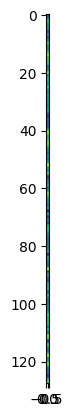

In [93]:
# fake image generator first
disc.zero_grad()
noise = torch.randn(BATCH_SIZE, 128, 1, 1, device=device)
print(noise[0].shape)
plt.imshow(noise[0].cpu())

torch.Size([3, 64, 64])


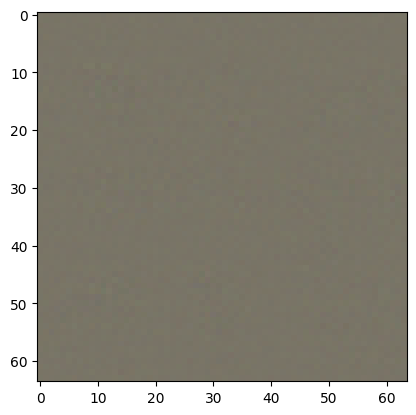

In [95]:
fake = gen(noise)
print(fake[0].shape)
plt.imshow(invTrans(fake[0]).cpu().detach().T)

In [ ]:
label = torch.full((BATCH_SIZE,), real_label, dtype=torch.float, device=device)
label.fill_(fake_label)
print(label.shape)

torch.Size([64])


In [ ]:
# Forward pass through discriminator
output, output_style = disc(fake.detach())
print(output.shape, output_style.shape)

torch.Size([64, 1, 1, 1]) torch.Size([64, 27, 1, 1])


In [ ]:
# Calculate loss on fake batch
errD_fake = loss(output.squeeze(), label)
print(errD_fake)

tensor(0.8478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


### next, real painting data discriminator

In [100]:
disc.zero_grad()
img, style_label = next(iter(dataloader)).values()
print("Loaded batch")
style_label = style_label.to(device)
img_cpu = img.to(device)
label = torch.full((BATCH_SIZE,), real_label, dtype=torch.float, device=device)
# print(style_label, label, img_cpu)

KeyboardInterrupt: ignored

### testing for part b) training the generator

In [ ]:
gen.zero_grad()
    
label.fill_(real_label)  # fake labels are real for generator cost
output, output_style = disc(fake.detach())

logsoftmax = nn.LogSoftmax(dim=1)
unif = torch.full((BATCH_SIZE, n_class), 1/n_class) # 27 art styles
unif = unif.to(device)
print(unif)

errG = loss(output.squeeze(), label)
print(errG)
errG = errG + torch.mean(-torch.sum(unif * logsoftmax(output_style), 1))
print(errG)
print(output.mean().item())

tensor([[0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
        [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
        [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
        ...,
        [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
        [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
        [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370]],
       device='cuda:0')
tensor(0.9155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(5.0713, device='cuda:0', grad_fn=<AddBackward0>)
0.4934428334236145


## Training Visualizations

In [70]:
len(G_losses) # just to check how much available for graphing. change indices below accordingly
# prob EPOCHS * number of batches per epoch

1065

### Training Loss

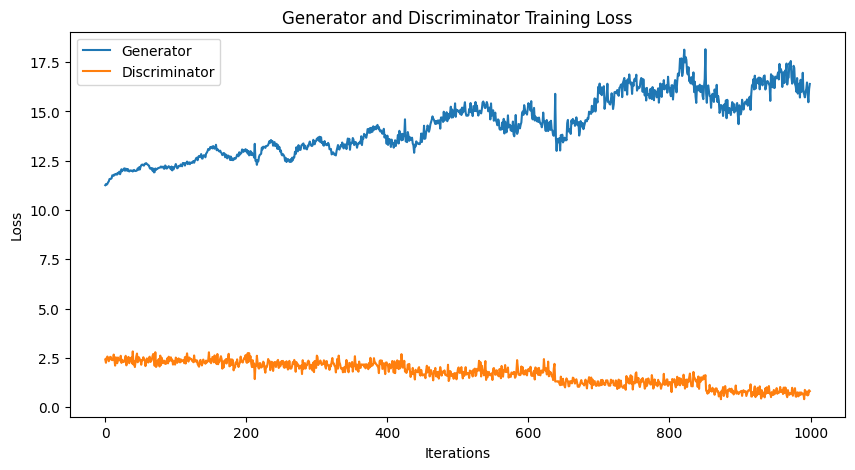

In [71]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Training Loss")
plt.plot(G_losses[:1000],label="Generator") # change numbers as needed
plt.plot(D_losses[:1000],label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [89]:
# one thing that should happen often enough (depending on your data and initialisation) is that both discriminator and 
# generator losses are converging to some permanent numbers.

# This loss convergence would normally signify that the GAN model found some optimum, where it can't improve more,
# which also should mean that it has learned well enough.

### Discriminator Entropy

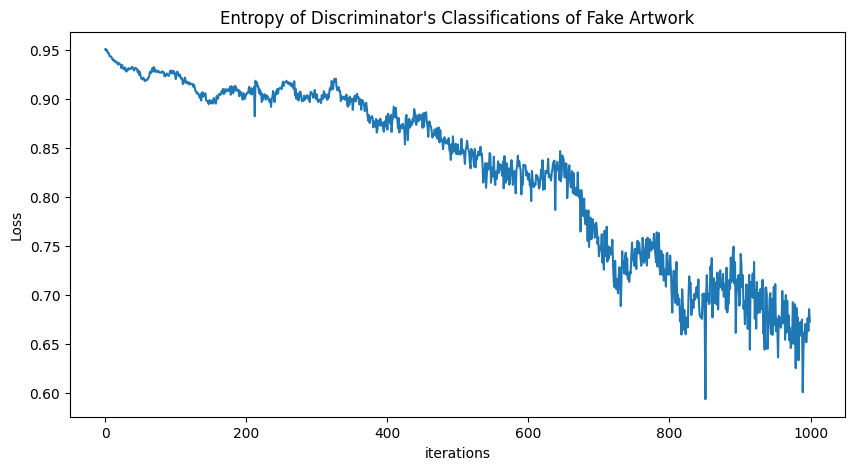

In [82]:
entropies_cpu = [e.detach().cpu().numpy() for e in entropies]

plt.figure(figsize=(10,5))
plt.title("Entropy of Discriminator's Classifications of Fake Artwork")
plt.plot(entropies_cpu[:1000])
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

### Generator Images Animation

In [105]:
# uh
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(invTrans(i),(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### Real vs. Fake Paintings

# temp: use subset of dataloader for speed

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

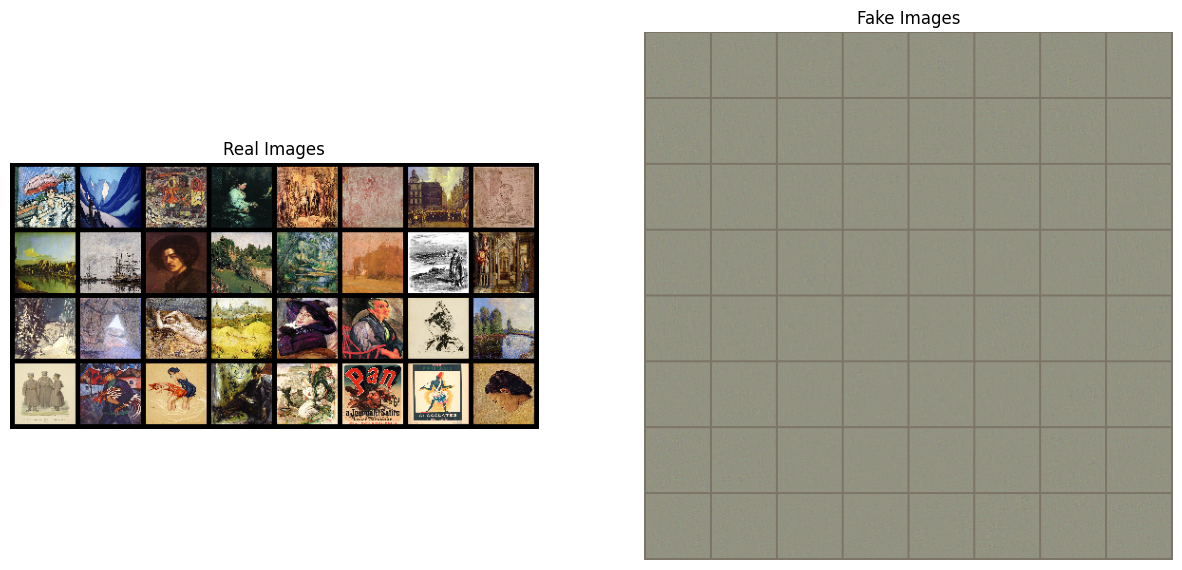

In [104]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_subset_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(invTrans(real_batch['images']).to(device)[:BATCH_SIZE], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(invTrans(img_list[-1]),(1,2,0)))
plt.show()

# actual

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(invTrans(real_batch['images']).to(device)[:BATCH_SIZE], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(invTrans(img_list[-1]),(1,2,0)))
plt.show()